

```
# This is formatted as code
```

# **Flight Ticket Price Prediction**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn import svm
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,r2_score


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

train_df =  pd.read_excel('TRAIN.xlsx')
test_df=pd.read_excel('TEST.xlsx')

**Append the dataset**

In [ ]:
big_df = train_df.append(test_df)


In [ ]:
big_df.dtypes

Airline               object
Date                  object
Departure Station     object
Arrival Station       object
Route Map             object
Departure Time        object
Arrival Time          object
Journey Time          object
Stops                 object
Extra Info            object
Price                float64
dtype: object

**Feature Engineering**

In [ ]:
big_df['Date'] = big_df['Date'].str.split('/').str[0]
big_df['Month'] = big_df['Date'].str.split('/').str[1]
big_df['Year'] = big_df['Date'].str.split('/').str[2]

In [ ]:
big_df['Date'].fillna("0",inplace = True)
big_df['Month'].fillna("0",inplace = True)
big_df['Year'].fillna("0",inplace = True)

In [ ]:
big_df['Date'] = big_df['Date'].astype(int)
big_df['Month'] = big_df['Month'].astype(int)
big_df['Year'] = big_df['Year'].astype(int)

In [ ]:
big_df.head()

,Airline,Date,Departure Station,Arrival Station,Route Map,Departure Time,Arrival Time,Journey Time,Stops,Extra Info,Price,Month,Year
0,IndiGo,24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0,0,0
1,Air India,1,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0,0,0
2,Jet Airways,9,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0,0,0
3,IndiGo,12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0,0,0
4,IndiGo,1,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0,0,0


In [ ]:
big_df=big_df.drop(['Date'], axis=1)

In [ ]:
big_df.head()

,Airline,Departure Station,Arrival Station,Route Map,Departure Time,Arrival Time,Journey Time,Stops,Extra Info,Price,Month,Year
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0,0,0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0,0,0
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0,0,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0,0,0
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0,0,0


In [ ]:
big_df['Arrival Time'] = big_df['Arrival Time'] .str.split(' ').str[0]

In [ ]:
big_df['Stops']=big_df['Stops'].fillna('1 stop')

In [ ]:
big_df.head()

,Airline,Departure Station,Arrival Station,Route Map,Departure Time,Arrival Time,Journey Time,Stops,Extra Info,Price,Month,Year
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10,2h 50m,non-stop,No info,3897.0,0,0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0,0,0
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,19h,2 stops,No info,13882.0,0,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0,0,0
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0,0,0


In [ ]:
big_df['Stops']=big_df['Stops'].replace('non-stop','0 stop')

In [ ]:
big_df['Stop'] = big_df['Stops'].str.split(' ').str[0]

In [ ]:
big_df['Stop'] = big_df['Stop'].astype(int)

In [ ]:
big_df=big_df.drop(['Stops'], axis=1)

In [ ]:
big_df.head()

,Airline,Departure Station,Arrival Station,Route Map,Departure Time,Arrival Time,Journey Time,Extra Info,Price,Month,Year,Stop
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10,2h 50m,No info,3897.0,0,0,0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,No info,7662.0,0,0,2
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,19h,No info,13882.0,0,0,2
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,No info,6218.0,0,0,1
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,No info,13302.0,0,0,1


In [ ]:
big_df['Arrival_Hour'] = big_df['Arrival Time'] .str.split(':').str[0]
big_df['Arrival_Minute'] = big_df['Arrival Time'] .str.split(':').str[1]

big_df['Arrival_Hour'] = big_df['Arrival_Hour'].astype(int)
big_df['Arrival_Minute'] = big_df['Arrival_Minute'].astype(int)
big_df=big_df.drop(['Arrival Time'], axis=1)

In [ ]:
big_df.head()

,Airline,Departure Station,Arrival Station,Route Map,Departure Time,Journey Time,Extra Info,Price,Month,Year,Stop,Arrival_Hour,Arrival_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,2h 50m,No info,3897.0,0,0,0,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,7h 25m,No info,7662.0,0,0,2,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,19h,No info,13882.0,0,0,2,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,5h 25m,No info,6218.0,0,0,1,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,4h 45m,No info,13302.0,0,0,1,21,35


In [ ]:
big_df['Dep_Hour'] = big_df['Departure Time'] .str.split(':').str[0]
big_df['Dep_Minute'] = big_df['Departure Time'] .str.split(':').str[1]
big_df['Dep_Hour'] = big_df['Dep_Hour'].astype(int)
big_df['Dep_Minute'] = big_df['Dep_Minute'].astype(int)
big_df=big_df.drop(['Departure Time'], axis=1)

In [ ]:
big_df['Route_1'] = big_df['Route Map'].str.split('→ ').str[0]
big_df['Route_2'] = big_df['Route Map'].str.split('→ ').str[1]
big_df['Route_3'] = big_df['Route Map'].str.split('→ ').str[2]
big_df['Route_4'] = big_df['Route Map'].str.split('→ ').str[3]
big_df['Route_5'] = big_df['Route Map'].str.split('→ ').str[4]

In [ ]:
big_df.head()

,Airline,Departure Station,Arrival Station,Route Map,Journey Time,Extra Info,Price,Month,Year,Stop,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,No info,3897.0,0,0,0,1,10,22,20,BLR,DEL,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,No info,7662.0,0,0,2,13,15,5,50,CCU,IXR,BBI,BLR,NaN
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,No info,13882.0,0,0,2,4,25,9,25,DEL,LKO,BOM,COK,NaN
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,No info,6218.0,0,0,1,23,30,18,5,CCU,NAG,BLR,NaN,NaN
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,No info,13302.0,0,0,1,21,35,16,50,BLR,NAG,DEL,NaN,NaN


In [ ]:
big_df['Price'].fillna((big_df['Price'].mean()), inplace=True)

In [ ]:
big_df['Route_1'].fillna("None",inplace = True)
big_df['Route_2'].fillna("None",inplace = True)
big_df['Route_3'].fillna("None",inplace = True)
big_df['Route_4'].fillna("None",inplace = True)
big_df['Route_5'].fillna("None",inplace = True)


In [ ]:
big_df.describe()



,Price,Month,Year,Stop,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute
count,10683.000000,10683.0,10683.0,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000
mean,9087.764333,0.0,0.0,0.824207,13.348778,24.690630,12.490686,24.411214
std,4227.148705,0.0,0.0,0.675199,6.859125,16.506036,5.748650,18.767980
min,1759.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6003.000000,0.0,0.0,0.000000,8.000000,10.000000,8.000000,5.000000
50%,9087.764333,0.0,0.0,1.000000,14.000000,25.000000,11.000000,25.000000
75%,11432.000000,0.0,0.0,1.000000,19.000000,35.000000,18.000000,40.000000
max,79512.000000,0.0,0.0,4.000000,23.000000,55.000000,23.000000,55.000000


In [ ]:
big_df=big_df.drop(['Route Map'], axis=1)
big_df=big_df.drop(['Journey Time'], axis=1)

In [ ]:
big_df.head()

,Airline,Departure Station,Arrival Station,Extra Info,Price,Month,Year,Stop,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,No info,3897.0,0,0,0,1,10,22,20,BLR,DEL,None,None,None
1,Air India,Kolkata,Banglore,No info,7662.0,0,0,2,13,15,5,50,CCU,IXR,BBI,BLR,None
2,Jet Airways,Delhi,Cochin,No info,13882.0,0,0,2,4,25,9,25,DEL,LKO,BOM,COK,None
3,IndiGo,Kolkata,Banglore,No info,6218.0,0,0,1,23,30,18,5,CCU,NAG,BLR,None,None
4,IndiGo,Banglore,New Delhi,No info,13302.0,0,0,1,21,35,16,50,BLR,NAG,DEL,None,None


**Converting the Categorical into integer variable**

In [ ]:

from sklearn.preprocessing import LabelEncoder

lb_encode = LabelEncoder()
big_df["Extra Info"] = lb_encode.fit_transform(big_df["Extra Info"])
big_df["Airline"] = lb_encode.fit_transform(big_df["Airline"])
big_df["Arrival Station"] = lb_encode.fit_transform(big_df["Arrival Station"])
big_df["Departure Station"] = lb_encode.fit_transform(big_df["Departure Station"])
big_df['Route_1']= lb_encode.fit_transform(big_df["Route_1"])
big_df['Route_2']= lb_encode.fit_transform(big_df["Route_2"])
big_df['Route_3']= lb_encode.fit_transform(big_df["Route_3"])
big_df['Route_4']= lb_encode.fit_transform(big_df["Route_4"])
big_df['Route_5']= lb_encode.fit_transform(big_df["Route_5"])

**Missing value validation**

In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns  

In [ ]:
missing_values_table(big_df)

Your selected dataframe has 17 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


**Split it into test and train**

In [ ]:
big_df.shape

(10683, 17)

In [ ]:
df_train = big_df[0:10683]
df_test = big_df[10683:]
df_test = df_test.drop(['Price'], axis =1)

In [ ]:
X = df_train.drop(['Price'], axis=1)
y = df_train.Price

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

**Model Building **

In [ ]:

from IPython.display import Image
from IPython.core.display import HTML 
Image(url = "http://i.imgur.com/QBuDOjs.jpg")

# Linear Regression

In [ ]:

#Build our model method
lm = LinearRegression()


In [ ]:
#Build our cross validation method
kfolds = KFold(n_splits=50,shuffle=True, random_state=100)

In [ ]:
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)

In [ ]:
benchmark_model = make_pipeline(RobustScaler(),
                                lm).fit(X=X_train, y=y_train)
cv_rmse(benchmark_model).mean()


3244.900258171505

In [ ]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
predict_lm=lm.predict(X_test)
predict_lm

array([ 5941.37772808,  5932.9292169 , 10092.04964026, ...,
        5941.37772808, 10003.95206084, 10484.01677493])

In [ ]:
df = pd.DataFrame(predict_lm) 
  
# saving the dataframe 
df.to_csv('pricewithLinearRegression.csv') 

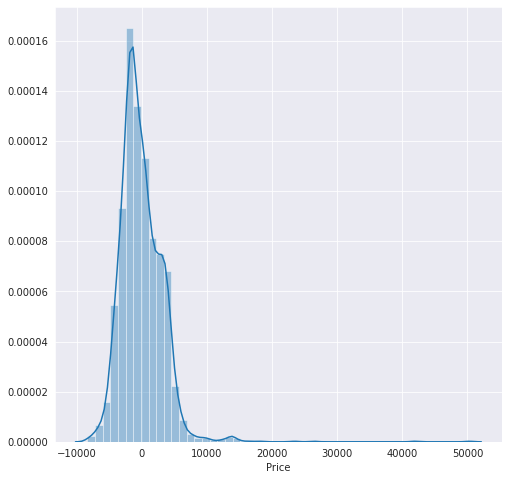

In [ ]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-predict_lm)
plt.show()

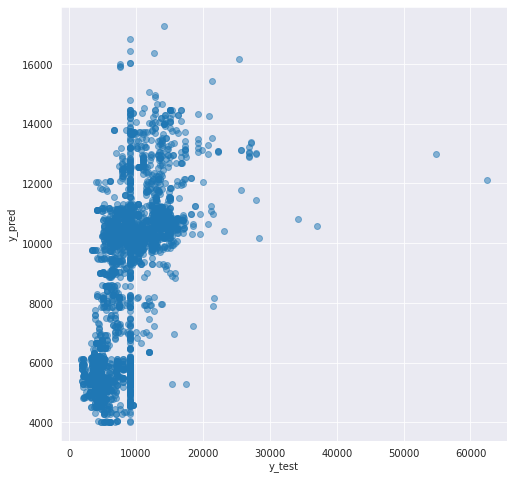

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, predict_lm, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [ ]:
r2_score(y_test,predict_lm)

0.3759713247679438

# GridSearch CV

In [ ]:
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from xgboost import XGBRegressor

In [ ]:
def modelfit(alg, dtrain, target, useTrainCV=True, 
             cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, 
                              label=y.values)
        
        print("\nGetting Cross-validation result..")
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,metrics='rmse', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval = True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    print("\nFitting algorithm to data...")
    alg.fit(dtrain, target, eval_metric='rmse')
        
    #Predict training set:
    print("\nPredicting from training data...")
    dtrain_predictions = alg.predict(dtrain)
        
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(mean_squared_error(target.values,
                                             dtrain_predictions)))

In [ ]:

#cv_rmse(xgb_fit).mean()

In [ ]:
xgb3 = XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                     min_child_weight=5 ,gamma=0, subsample=0.7,max_bin=20,
                     colsample_bytree=0.8,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)

xgb_fit = xgb3.fit(X_train, y_train)

[14:16:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
predict_xg=xgb3.predict(X_test)
predict_xg

array([ 5909.6953,  5975.965 , 10094.481 , ...,  5909.6953, 10184.417 ,
        7794.029 ], dtype=float32)

In [ ]:
df = pd.DataFrame(predict_xg) 
  
# saving the dataframe 
df.to_csv('pricewithGridSearchCV.csv') 

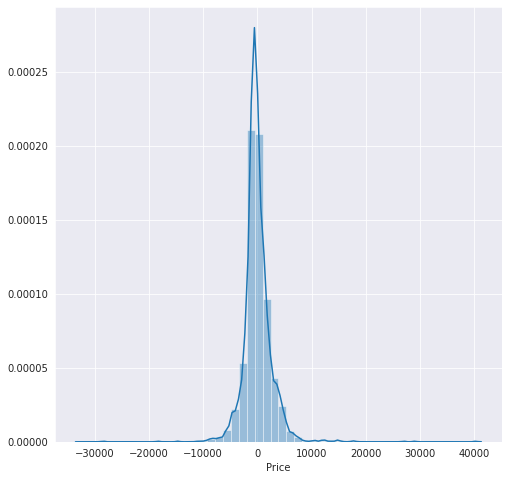

In [ ]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-predict_xg)
plt.show()

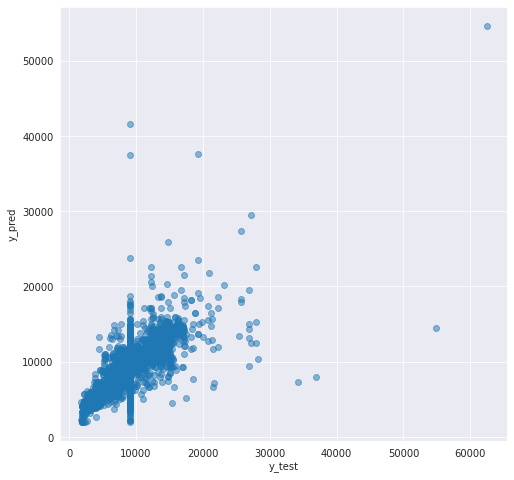

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, predict_xg, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [ ]:
#accuracy_score(y_test, predict_xg)

In [ ]:
cv_rmse(xgb_fit).mean()

[14:16:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

2694.6730053227247

# **Randomized Search CV**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]


In [ ]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
rf_random = RandomizedSearchCV( estimator = reg_rf , param_distributions= random_grid , scoring='neg_mean_squared_error',
                               n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.7s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.6s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.6s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.5s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.5s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   5.2s
[CV] n_estimators=1100, min_samples_split=10, mi

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 700}

In [ ]:
prediction = rf_random.predict(X_test)

In [ ]:
df = pd.DataFrame(prediction) 
  
# saving the dataframe 
df.to_csv('pricewithRandomizedSearchCV.csv') 

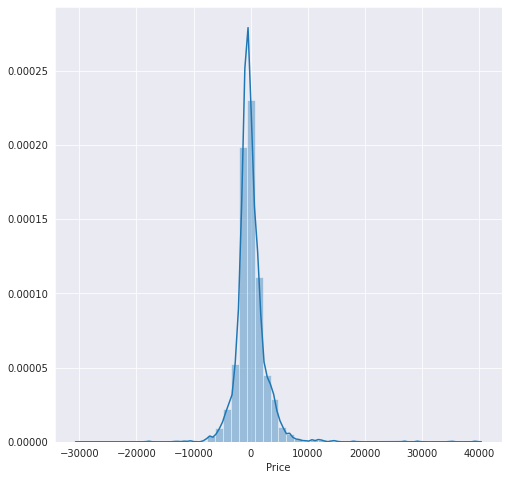

In [ ]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

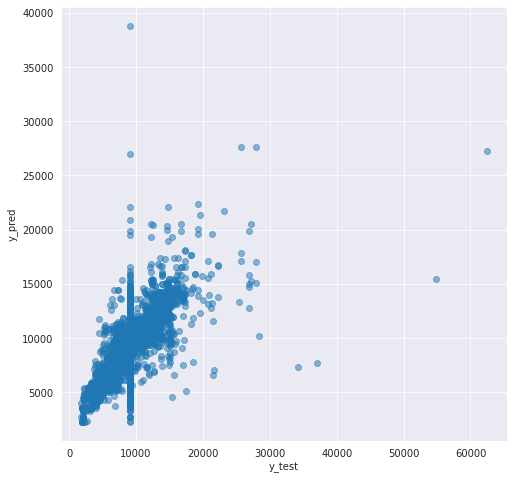

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1660.4719420079955
MSE: 7134040.084375961
RMSE: 2670.9623891728543
